<a href="https://www.kaggle.com/code/samithsachidanandan/drw-crypto-predict-lgb-xgb-lasso-elastic-ensembe?scriptVersionId=242566603" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 85.7 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


# Imports and configs

In [2]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from scipy.stats import pearsonr
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import gc

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"

    target = "label"
    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [5]:
cols_to_drop = [
    'X697', 'X698', 'X699', 'X700', 'X701', 'X702', 'X703', 'X704', 'X705', 'X706', 
    'X707', 'X708', 'X709', 'X710', 'X711', 'X712', 'X713', 'X714', 'X715', 'X716',
    'X717', 'X864', 'X867', 'X869', 'X870', 'X871', 'X872', 'X104', 'X110', 'X116',
    'X122', 'X128', 'X134', 'X140', 'X146', 'X152', 'X158', 'X164', 'X170', 'X176',
    'X182', 'X351', 'X357', 'X363', 'X369', 'X375', 'X381', 'X387', 'X393', 'X399',
    'X405', 'X411', 'X417', 'X423', 'X429'
]

In [6]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=["label"] + cols_to_drop)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

# Create interaction features for train
train['bid_ask_interaction'] = train['bid_qty'] * train['ask_qty']
train['bid_buy_interaction'] = train['bid_qty'] * train['buy_qty']
train['bid_sell_interaction'] = train['bid_qty'] * train['sell_qty']
train['ask_buy_interaction'] = train['ask_qty'] * train['buy_qty']
train['ask_sell_interaction'] = train['ask_qty'] * train['sell_qty']
train['buy_sell_interaction'] = train['buy_qty'] * train['sell_qty']

# Calculate spread indicators for train
train['spread_indicator'] = (train['ask_qty'] - train['bid_qty']) / (train['ask_qty'] + train['bid_qty'] + 1e-8)

# Volume-weighted features for train
train['volume_weighted_buy'] = train['buy_qty'] * train['volume']
train['volume_weighted_sell'] = train['sell_qty'] * train['volume']
train['volume_weighted_bid'] = train['bid_qty'] * train['volume']
train['volume_weighted_ask'] = train['ask_qty'] * train['volume']

# NEW FEATURES - Add ratio features
train['buy_sell_ratio'] = train['buy_qty'] / (train['sell_qty'] + 1e-8)
train['bid_ask_ratio'] = train['bid_qty'] / (train['ask_qty'] + 1e-8)

# NEW FEATURES - Add order flow imbalance
train['order_flow_imbalance'] = (train['buy_qty'] - train['sell_qty']) / (train['volume'] + 1e-8)

# NEW FEATURES - Add market pressure indicators
train['buying_pressure'] = train['buy_qty'] / (train['volume'] + 1e-8)
train['selling_pressure'] = train['sell_qty'] / (train['volume'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES - Liquidity measures
train['total_liquidity'] = train['bid_qty'] + train['ask_qty']
train['liquidity_imbalance'] = (train['bid_qty'] - train['ask_qty']) / (train['total_liquidity'] + 1e-8)
train['relative_spread'] = (train['ask_qty'] - train['bid_qty']) / (train['volume'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES - Trade intensity
train['trade_intensity'] = (train['buy_qty'] + train['sell_qty']) / (train['volume'] + 1e-8)
train['avg_trade_size'] = train['volume'] / (train['buy_qty'] + train['sell_qty'] + 1e-8)
train['net_trade_flow'] = (train['buy_qty'] - train['sell_qty']) / (train['buy_qty'] + train['sell_qty'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES - Market depth and activity
train['depth_ratio'] = train['total_liquidity'] / (train['volume'] + 1e-8)
train['volume_participation'] = (train['buy_qty'] + train['sell_qty']) / (train['total_liquidity'] + 1e-8)
train['market_activity'] = train['volume'] * train['total_liquidity']

# ADDITIONAL NEW MARKET FEATURES - Execution quality indicators
train['effective_spread_proxy'] = np.abs(train['buy_qty'] - train['sell_qty']) / (train['volume'] + 1e-8)
train['realized_volatility_proxy'] = np.abs(train['order_flow_imbalance']) * train['volume']

# ADDITIONAL NEW MARKET FEATURES - Normalized volumes
train['normalized_buy_volume'] = train['buy_qty'] / (train['bid_qty'] + 1e-8)
train['normalized_sell_volume'] = train['sell_qty'] / (train['ask_qty'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES - Complex interactions
train['liquidity_adjusted_imbalance'] = train['order_flow_imbalance'] * train['depth_ratio']
train['pressure_spread_interaction'] = train['buying_pressure'] * train['spread_indicator']

# Replace any inf or -inf values with NaN, then fill NaN with 0
train = train.replace([np.inf, -np.inf], np.nan)
train = train.fillna(0)

# Create same features for test
test['bid_ask_interaction'] = test['bid_qty'] * test['ask_qty']
test['bid_buy_interaction'] = test['bid_qty'] * test['buy_qty']
test['bid_sell_interaction'] = test['bid_qty'] * test['sell_qty']
test['ask_buy_interaction'] = test['ask_qty'] * test['buy_qty']
test['ask_sell_interaction'] = test['ask_qty'] * test['sell_qty']
test['buy_sell_interaction'] = test['buy_qty'] * test['sell_qty']

# Calculate spread indicators for test
test['spread_indicator'] = (test['ask_qty'] - test['bid_qty']) / (test['ask_qty'] + test['bid_qty'] + 1e-8)

# Volume-weighted features for test
test['volume_weighted_buy'] = test['buy_qty'] * test['volume']
test['volume_weighted_sell'] = test['sell_qty'] * test['volume']
test['volume_weighted_bid'] = test['bid_qty'] * test['volume']
test['volume_weighted_ask'] = test['ask_qty'] * test['volume']

# NEW FEATURES FOR TEST - Add ratio features
test['buy_sell_ratio'] = test['buy_qty'] / (test['sell_qty'] + 1e-8)
test['bid_ask_ratio'] = test['bid_qty'] / (test['ask_qty'] + 1e-8)

# NEW FEATURES FOR TEST - Add order flow imbalance
test['order_flow_imbalance'] = (test['buy_qty'] - test['sell_qty']) / (test['volume'] + 1e-8)

# NEW FEATURES FOR TEST - Add market pressure indicators
test['buying_pressure'] = test['buy_qty'] / (test['volume'] + 1e-8)
test['selling_pressure'] = test['sell_qty'] / (test['volume'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES FOR TEST - Liquidity measures
test['total_liquidity'] = test['bid_qty'] + test['ask_qty']
test['liquidity_imbalance'] = (test['bid_qty'] - test['ask_qty']) / (test['total_liquidity'] + 1e-8)
test['relative_spread'] = (test['ask_qty'] - test['bid_qty']) / (test['volume'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES FOR TEST - Trade intensity
test['trade_intensity'] = (test['buy_qty'] + test['sell_qty']) / (test['volume'] + 1e-8)
test['avg_trade_size'] = test['volume'] / (test['buy_qty'] + test['sell_qty'] + 1e-8)
test['net_trade_flow'] = (test['buy_qty'] - test['sell_qty']) / (test['buy_qty'] + test['sell_qty'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES FOR TEST - Market depth and activity
test['depth_ratio'] = test['total_liquidity'] / (test['volume'] + 1e-8)
test['volume_participation'] = (test['buy_qty'] + test['sell_qty']) / (test['total_liquidity'] + 1e-8)
test['market_activity'] = test['volume'] * test['total_liquidity']

# ADDITIONAL NEW MARKET FEATURES FOR TEST - Execution quality indicators
test['effective_spread_proxy'] = np.abs(test['buy_qty'] - test['sell_qty']) / (test['volume'] + 1e-8)
test['realized_volatility_proxy'] = np.abs(test['order_flow_imbalance']) * test['volume']

# ADDITIONAL NEW MARKET FEATURES FOR TEST - Normalized volumes
test['normalized_buy_volume'] = test['buy_qty'] / (test['bid_qty'] + 1e-8)
test['normalized_sell_volume'] = test['sell_qty'] / (test['ask_qty'] + 1e-8)

# ADDITIONAL NEW MARKET FEATURES FOR TEST - Complex interactions
test['liquidity_adjusted_imbalance'] = test['order_flow_imbalance'] * test['depth_ratio']
test['pressure_spread_interaction'] = test['buying_pressure'] * test['spread_indicator']

# Replace any inf or -inf values with NaN, then fill NaN with 0
test = test.replace([np.inf, -np.inf], np.nan)
test = test.fillna(0)

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test

# Ensure no inf values in X and X_test
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

# Force garbage collection before training
gc.collect()

print(f"Training data shape: {X.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Number of features: {X.shape[1]}")
print("\n")


Reducing memory usage for: train
--- Memory usage before: 3374.26 MB
--- Memory usage after: 843.57 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 3448.84 MB
--- Memory usage after: 862.21 MB
--- Decreased memory usage by 75.0%

Training data shape: (525887, 871)
Test data shape: (538150, 871)
Number of features: 871




# Training base models

In [7]:
class Trainer:
    def __init__(self, model):
        self.model = model

    def fit_predict(self, X, y, X_test):
        print(f"Training {self.model.__class__.__name__}\n")

        fold_scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])

        split = KFold(n_splits=CFG.n_folds, shuffle=False).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):

            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_preds = model.predict(X_val)
            oof_preds[val_idx] = y_preds
            
            temp_test_preds = model.predict(X_test)
            test_preds += temp_test_preds / CFG.n_folds

            fold_score = pearsonr(y_val, y_preds)[0]
            fold_scores.append(fold_score)

            print(f"--- Fold {fold_idx} - Score: {fold_score:.6f}")

            del X_train, y_train, X_val, y_val, y_preds, model, temp_test_preds
            gc.collect()

        overall_score = pearsonr(y, oof_preds)[0]
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        
        print(f"\n------ Overall Score: {overall_score:.6f} - Mean Score: {mean_score:.6f} ± {std_score:.6f}")
        
        return oof_preds, test_preds, fold_scores
    
    def tune(self, X, y):
        fold_scores = []
        
        split = KFold(n_splits=CFG.n_folds, shuffle=False).split(X, y)
        for train_idx, val_idx in split:
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_preds = model.predict(X_val)
            fold_score = pearsonr(y_val, y_preds)[0]
            fold_scores.append(fold_score)

            del X_train, y_train, X_val, y_val, y_preds, model
            gc.collect()

        return np.mean(fold_scores)

In [8]:
lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.34695458228489784,
    "learning_rate": 0.031023014900595287,
    "min_child_samples": 30,
    "min_child_weight": 0.4727729225033618,
    "n_estimators": 220,
    "n_jobs": -1,
    "num_leaves": 58,
    "random_state": 42,
    "reg_alpha": 38.665994901468224,
    "reg_lambda": 92.76991677464294,
    "subsample": 0.4810891284493255,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}


lasso_params = {
    "alpha": 0.01,
    "fit_intercept": True,
    "max_iter": 1000,
    "tol": 0.0001,
    "selection": "cyclic",
    "random_state": 42
}

elasticnet_params = {
    "alpha": 0.01,           
    "l1_ratio": 0.5,         
    "fit_intercept": True,
    "max_iter": 1000,
    "tol": 0.0001,
    "random_state": 42
}

In [9]:
scores = {}
oof_preds = {}
test_preds = {}

## LightGBM (goss)

In [10]:
lgbm_goss_trainer = Trainer(LGBMRegressor(**lgbm_goss_params))

oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"] = lgbm_goss_trainer.fit_predict(X, y, X_test)

Training LGBMRegressor

--- Fold 0 - Score: 0.171434
--- Fold 1 - Score: 0.103769
--- Fold 2 - Score: 0.029950
--- Fold 3 - Score: 0.129101
--- Fold 4 - Score: 0.077305

------ Overall Score: 0.094793 - Mean Score: 0.102312 ± 0.047664


## XGBoost

In [11]:
xgb_trainer = Trainer(XGBRegressor(**xgb_params))

oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test)

Training XGBRegressor

--- Fold 0 - Score: 0.201800
--- Fold 1 - Score: 0.110252
--- Fold 2 - Score: 0.067265
--- Fold 3 - Score: 0.134392
--- Fold 4 - Score: 0.066571

------ Overall Score: 0.108755 - Mean Score: 0.116056 ± 0.050102


## Lasso

In [12]:
lasso_trainer = Trainer(Lasso(**lasso_params))

oof_preds["Lasso"], test_preds["Lasso"], scores["Lasso"] = lasso_trainer.fit_predict(X, y, X_test)

Training Lasso

--- Fold 0 - Score: 0.181396
--- Fold 1 - Score: 0.091195
--- Fold 2 - Score: 0.056608
--- Fold 3 - Score: 0.158987
--- Fold 4 - Score: 0.096381

------ Overall Score: 0.097756 - Mean Score: 0.116913 ± 0.046147


## ElasticNet

In [13]:
elasticnet_trainer = Trainer(ElasticNet(**elasticnet_params))

oof_preds["ElasticNet"], test_preds["ElasticNet"], scores["ElasticNet"] = elasticnet_trainer.fit_predict(X, y, X_test)

Training ElasticNet

--- Fold 0 - Score: 0.188836
--- Fold 1 - Score: 0.088257
--- Fold 2 - Score: 0.049079
--- Fold 3 - Score: 0.162943
--- Fold 4 - Score: 0.092053

------ Overall Score: 0.101564 - Mean Score: 0.116234 ± 0.051633


# Ensembling with Ridge

In [14]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [15]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 100),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(Ridge(**params))
    return trainer.tune(X, y)

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-29 10:24:17,730] A new study created in memory with name: no-name-e5f8b1a2-16c9-46f7-908b-bca6aea7744f
[I 2025-05-29 10:24:20,450] Trial 0 finished with value: 0.13001926024808094 and parameters: {'alpha': 16.125554018491094, 'tol': 0.003616419215486742}. Best is trial 0 with value: 0.13001926024808094.
[I 2025-05-29 10:24:20,592] Trial 1 finished with value: 0.13014926166514135 and parameters: {'alpha': 98.68010672904752, 'tol': 0.005437730142584709}. Best is trial 1 with value: 0.13014926166514135.
[I 2025-05-29 10:24:20,810] Trial 2 finished with value: 0.13014026348508265 and parameters: {'alpha': 92.42346376842696, 'tol': 0.007415207903932423}. Best is trial 1 with value: 0.13014926166514135.
[I 2025-05-29 10:24:21,061] Trial 3 finished with value: 0.13011576113521064 and parameters: {'alpha': 75.82137229002227, 'tol': 0.006765716024064881}. Best is trial 1 with value: 0.13014926166514135.
[I 2025-05-29 10:24:23,502] Trial 5 finished with value: 0.13012214976640846 and 

In [16]:
ridge_trainer = Trainer(Ridge(**ridge_params))

_, ridge_test_preds, scores["Ridge (ensemble)"] = ridge_trainer.fit_predict(X, y, X_test)

Training Ridge

--- Fold 0 - Score: 0.223236
--- Fold 1 - Score: 0.111905
--- Fold 2 - Score: 0.061237
--- Fold 3 - Score: 0.165833
--- Fold 4 - Score: 0.088545

------ Overall Score: 0.093594 - Mean Score: 0.130151 ± 0.057881


# Submission

In [17]:
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ridge_test_preds
sub.to_csv("submission.csv", index=False)
sub.head()

,ID,prediction
0,1,0.084509
1,2,0.011372
2,3,0.024137
3,4,-0.010886
4,5,0.185358


# Results

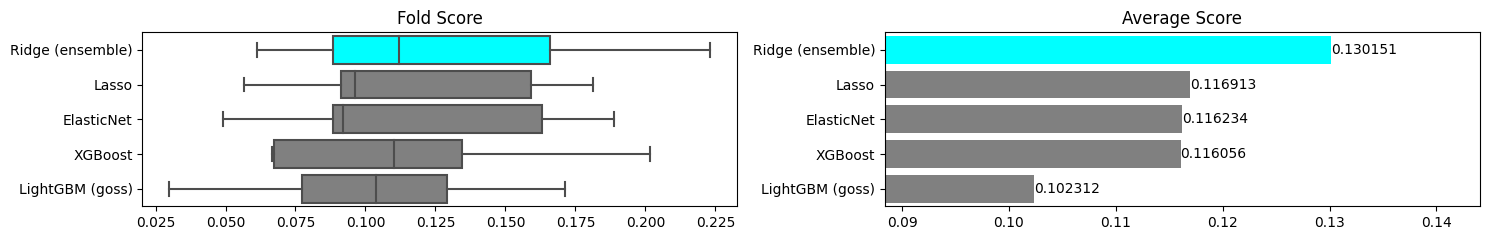

In [18]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=False)
order = scores.mean().sort_values(ascending=False).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.5))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold Score")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average Score")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

### Acknowledgements: 

[https://www.kaggle.com/code/ravaghi/drw-crypto-market-prediction-ensemble](https://www.kaggle.com/code/ravaghi/drw-crypto-market-prediction-ensemble)

[https://www.kaggle.com/code/tayloramarel/drw-crypto-market-prediction-ensemble](https://www.kaggle.com/code/tayloramarel/drw-crypto-market-prediction-ensemble)
